# Sobel

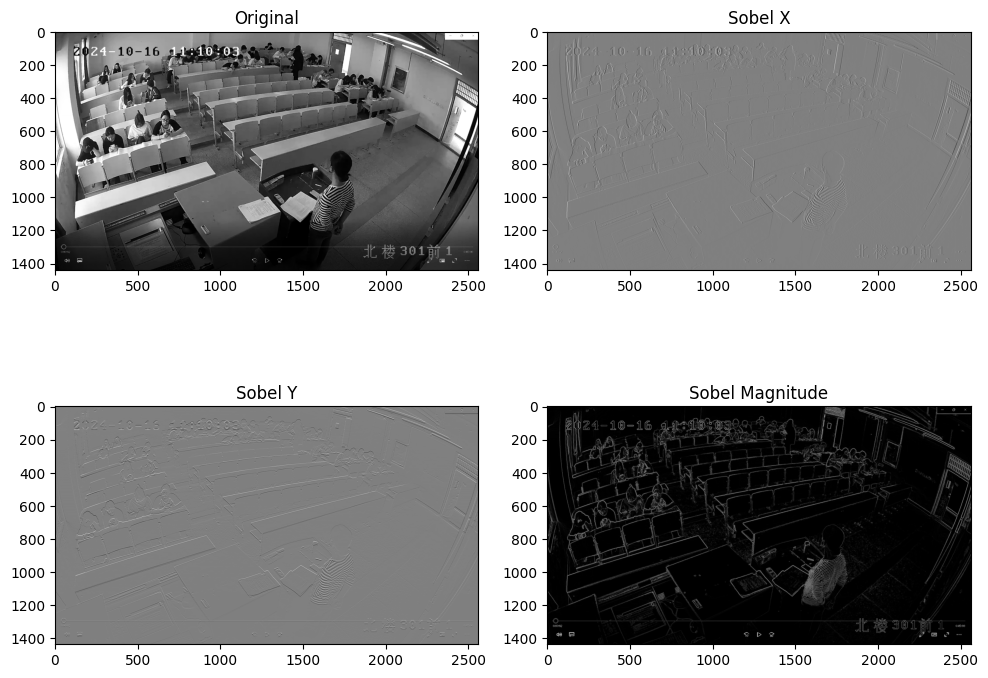

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 加载图像（灰度模式）
image = cv2.imread("example.png", cv2.IMREAD_GRAYSCALE)

# Sobel算子计算梯度
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # 水平方向
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # 垂直方向

# 计算梯度幅值
sobel_magnitude = cv2.magnitude(sobel_x, sobel_y)

# 显示结果
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1), plt.title('Original'), plt.imshow(image, cmap='gray')
plt.subplot(2, 2, 2), plt.title('Sobel X'), plt.imshow(sobel_x, cmap='gray')
plt.subplot(2, 2, 3), plt.title('Sobel Y'), plt.imshow(sobel_y, cmap='gray')
plt.subplot(2, 2, 4), plt.title('Sobel Magnitude'), plt.imshow(sobel_magnitude, cmap='gray')
plt.tight_layout()
plt.show()


# Canny

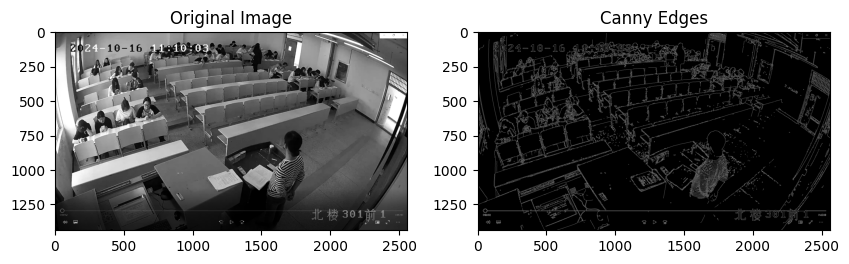

In [4]:
# 加载图像（灰度模式）
image = cv2.imread('example.png', cv2.IMREAD_GRAYSCALE)

# 使用Canny边缘检测
edges = cv2.Canny(image, 100, 200)  # 参数为低阈值和高阈值

# 显示原图和边缘检测结果
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.title('Original Image'), plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2), plt.title('Canny Edges'), plt.imshow(edges, cmap='gray')
plt.show()


# Canny 完整版

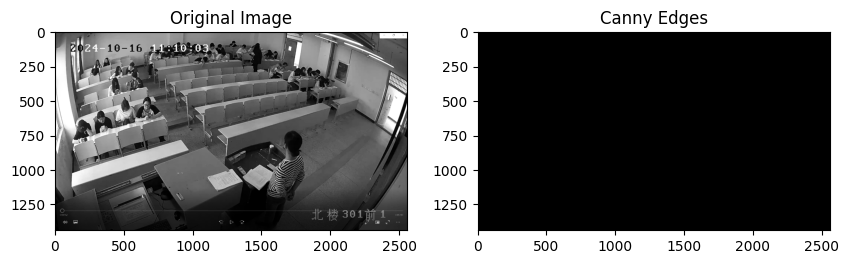

In [3]:
def gaussian_kernel(size, sigma):
    """生成高斯核"""
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

def apply_filter(image, kernel):
    """对图像进行卷积"""
    h, w = image.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    result = np.zeros_like(image)
    for i in range(h):
        for j in range(w):
            region = padded_image[i:i+kh, j:j+kw]
            result[i, j] = np.sum(region * kernel)
    return result

def sobel_filters(image):
    """计算梯度"""
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    grad_x = apply_filter(image, sobel_x)
    grad_y = apply_filter(image, sobel_y)
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    direction = np.arctan2(grad_y, grad_x)
    return magnitude, direction

def non_max_suppression(magnitude, direction):
    """非极大值抑制"""
    h, w = magnitude.shape
    suppressed = np.zeros((h, w), dtype=np.float32)
    angle = direction * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, h-1):
        for j in range(1, w-1):
            try:
                # 梯度方向与其相邻像素点的值比较
                q = 255
                r = 255

                if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                    q = magnitude[i, j+1]
                    r = magnitude[i, j-1]
                elif 22.5 <= angle[i, j] < 67.5:
                    q = magnitude[i+1, j-1]
                    r = magnitude[i-1, j+1]
                elif 67.5 <= angle[i, j] < 112.5:
                    q = magnitude[i+1, j]
                    r = magnitude[i-1, j]
                elif 112.5 <= angle[i, j] < 157.5:
                    q = magnitude[i-1, j-1]
                    r = magnitude[i+1, j+1]

                if magnitude[i, j] >= q and magnitude[i, j] >= r:
                    suppressed[i, j] = magnitude[i, j]
                else:
                    suppressed[i, j] = 0

            except IndexError as e:
                pass
    return suppressed

def threshold(suppressed, low, high):
    """双阈值处理"""
    strong = 255
    weak = 75
    result = np.zeros_like(suppressed)
    strong_i, strong_j = np.where(suppressed >= high)
    weak_i, weak_j = np.where((suppressed >= low) & (suppressed < high))
    result[strong_i, strong_j] = strong
    result[weak_i, weak_j] = weak
    return result, weak, strong

def edge_tracking(result, weak, strong):
    """边缘连接"""
    h, w = result.shape
    for i in range(1, h-1):
        for j in range(1, w-1):
            if result[i, j] == weak:
                if ((result[i+1, j-1:j+2] == strong).any() or
                        (result[i-1, j-1:j+2] == strong).any() or
                        (result[i, [j-1, j+1]] == strong).any()):
                    result[i, j] = strong
                else:
                    result[i, j] = 0
    return result

# 加载灰度图像
image = cv2.imread('example.png', cv2.IMREAD_GRAYSCALE)

# 1. 高斯滤波
gaussian = gaussian_kernel(5, 1)
smoothed = apply_filter(image, gaussian)

# 2. 梯度计算
magnitude, direction = sobel_filters(smoothed)

# 3. 非极大值抑制
suppressed = non_max_suppression(magnitude, direction)

# 4. 双阈值处理
low, high = 50, 150
thresholded, weak, strong = threshold(suppressed, low, high)

# 5. 边缘连接
edges = edge_tracking(thresholded, weak, strong)

# 显示结果
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1), plt.title('Original Image'), plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2), plt.title('Canny Edges'), plt.imshow(edges, cmap='gray')
plt.show()


# 恺明初始化

In [15]:
import torch
 
class DemoNet(torch.nn.Module):
    def __init__(self):
        super(DemoNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 1, 3)
        print('random init:', self.conv1.weight)
        '''
            kaiming 初始化方法中服从均匀分布 U～（-bound, bound）, bound = sqrt(6/(1+a^2)*fan_in)
            a 为激活函数的负半轴的斜率，relu 是 0
            mode- 可选为 fan_in 或 fan_out, fan_in 使正向传播时，方差一致; fan_out 使反向传播时，方差一致
            nonlinearity- 可选 relu 和 leaky_relu ，默认值为 。 leaky_relu
        '''
        torch.nn.init.kaiming_uniform_(self.conv1.weight, a=0, mode='fan_out')
        print('xavier_uniform_:', self.conv1.weight)
 
        '''
            kaiming 初始化方法中服从正态分布，此为 0 均值的正态分布，N～ (0,std),其中 std = sqrt(2/(1+a^2)*fan_in)
            a 为激活函数的负半轴的斜率，relu 是 0
            mode- 可选为 fan_in 或 fan_out, fan_in 使正向传播时，方差一致;fan_out 使反向传播时，方差一致
            nonlinearity- 可选 relu 和 leaky_relu ，默认值为 。 leaky_relu
        '''
        torch.nn.init.kaiming_normal_(self.conv1.weight, a=0, mode='fan_out')
        print('kaiming_normal_:', self.conv1.weight)
 
 
if __name__ == '__main__':
    demoNet = DemoNet()

random init: Parameter containing:
tensor([[[[-0.0176, -0.1491, -0.1341],
          [-0.0502, -0.0324, -0.2369],
          [-0.0971, -0.1202,  0.0893]]]], requires_grad=True)
xavier_uniform_: Parameter containing:
tensor([[[[ 0.5109,  0.6256, -0.6764],
          [ 0.1321, -0.3319,  0.7024],
          [-0.0348,  0.3846,  0.1899]]]], requires_grad=True)
kaiming_normal_: Parameter containing:
tensor([[[[-0.3971,  0.4783,  0.2792],
          [-0.5270,  0.6980, -0.9456],
          [ 0.1939,  0.1768,  0.1160]]]], requires_grad=True)


# 金字塔池化

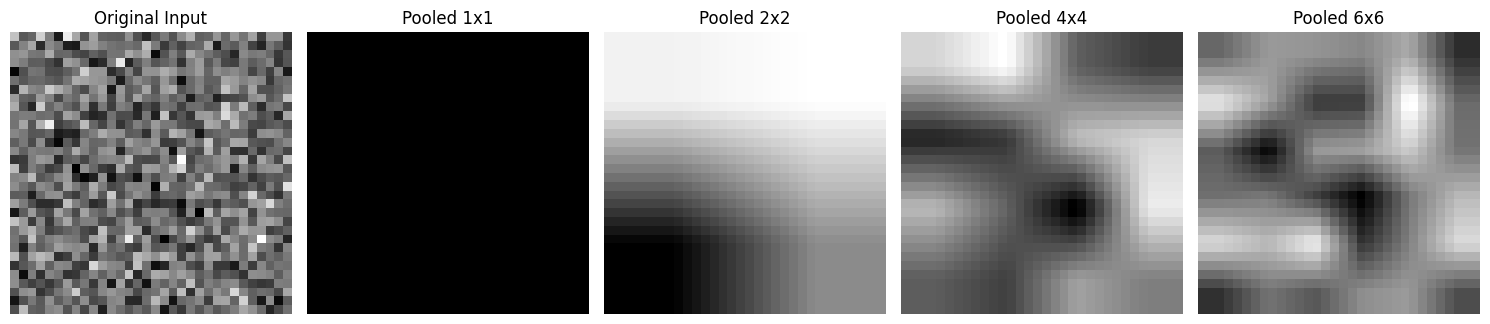

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class PyramidPoolingModule(nn.Module):
    def __init__(self, pool_sizes=[1, 2, 4, 6]):
        super(PyramidPoolingModule, self).__init__()
        self.pool_sizes = pool_sizes

    def forward(self, x):
        # 获取输入的尺寸
        batch_size, channels, height, width = x.size()

        # 存储池化结果
        pyramid_pooling_results = []

        for pool_size in self.pool_sizes:
            # 使用池化操作进行下采样
            pool = F.adaptive_avg_pool2d(x, (pool_size, pool_size))
            pyramid_pooling_results.append(pool)

        # 上采样所有池化结果，使它们的尺寸一致
        pyramid_pooling_results = [F.interpolate(pool, size=(height, width), mode='bilinear', align_corners=False)
                                   for pool in pyramid_pooling_results]

        # 将所有池化结果在通道维度上拼接
        out = torch.cat(pyramid_pooling_results, dim=1)

        return out, pyramid_pooling_results  # 返回池化后的结果用于可视化

# 可视化函数
def visualize_pyramid_pooling(x, pyramid_pooling_results, pool_sizes):
    batch_size, channels, height, width = x.size()

    # 创建子图
    fig, axes = plt.subplots(1, len(pool_sizes) + 1, figsize=(15, 5))

    # 原始输入
    axes[0].imshow(x[0, 0].cpu().detach().numpy(), cmap='gray')
    axes[0].set_title("Original Input")
    axes[0].axis('off')

    # 显示每个池化尺度的特征图
    for i, (pool_size, pooled) in enumerate(zip(pool_sizes, pyramid_pooling_results)):
        axes[i + 1].imshow(pooled[0, 0].cpu().detach().numpy(), cmap='gray')
        axes[i + 1].set_title(f"Pooled {pool_size}x{pool_size}")
        axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

# 测试代码
if __name__ == "__main__":
    # 假设输入的特征图大小为 (batch_size=1, channels=64, height=32, width=32)
    x = torch.randn(1, 64, 32, 32)

    # 创建金字塔池化模块
    psp = PyramidPoolingModule(pool_sizes=[1, 2, 4, 6])

    # 前向传播，获取池化结果
    out, pyramid_pooling_results = psp(x)

    # 可视化金字塔池化过程
    visualize_pyramid_pooling(x, pyramid_pooling_results, pool_sizes=[1, 2, 4, 6])
